<h1 align='center'><u>SMS Spam Detection</u></h1>



In [1]:
!pip install -U spacy

In [2]:
!pip install pyspellchecker

In [3]:
!pip install bs4

In [4]:
# Import Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import textwrap as tw
import matplotlib.pyplot as plt

# learning Curves
from sklearn.model_selection import learning_curve

# save and load models
import joblib

import re
from bs4 import BeautifulSoup

from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import spacy
from spacy.matcher import Matcher
from spacy.tokens import Token


import nltk
from nltk.stem.porter import PorterStemmer


from sklearn.model_selection import train_test_split
from collections import Counter
from xgboost import XGBClassifier
from sklearn import metrics
from spellchecker import SpellChecker

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
spacy.__version__

'3.1.3'

In [7]:
data_folder = Path('/content/drive/MyDrive/Data/Spam_detection/')
spacy_folder = Path('/content/drive/MyDrive/Data/spacy')

In [8]:
# load spacy model
model = spacy_folder /'en_core_web_sm-3.1.0'/'en_core_web_sm'/'en_core_web_sm-3.1.0'
nlp = spacy.load(model)

# Load the dataset 

- Using the spam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link.  

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Renaming the columns as label and message

- Find the %  ham amd spam in the data.





In [9]:
# location of data file
spam_file = data_folder / 'spam.csv'

# creating Pandas Dataframe
spam = pd.read_csv(spam_file, index_col=0,encoding = 'ISO-8859-1')

In [10]:
# print shape of the dataset
print(f'Shape of data set is : {spam.shape}')

Shape of data set is : (5572, 4)


In [11]:
#Printing top 5 records
spam.head()

,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
v1,,,,
ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [12]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5572 entries, ham to ham
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v2          5572 non-null   object
 1   Unnamed: 2  50 non-null     object
 2   Unnamed: 3  12 non-null     object
 3   Unnamed: 4  6 non-null      object
dtypes: object(4)
memory usage: 217.7+ KB


In [13]:
spam.drop(columns = ['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], inplace=True)
spam.reset_index(inplace=True)
spam.rename(columns={'v1':'label', 'v2':'message'},inplace=True)

# Printing basic info
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [14]:
spam.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
# Checking for missing values
spam.isna().sum()

label      0
message    0
dtype: int64

In [16]:
# Checking distribution of class labels for train dataset
spam['label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [17]:
# Checking distribution of class labels for train dataset
spam['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [18]:
save_model_folder = Path('/content/drive/MyDrive/Colab Notebooks/NLP/saved_models')

# Metric for evaluating model
Data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So we need to choose a different metric.


In [19]:
# Creating a scorer for F2 score so that we can given an emphases on the minority class predictions i.e higher recall
from sklearn.metrics import fbeta_score, make_scorer
f2score = make_scorer(fbeta_score, beta=2)
f2score

make_scorer(fbeta_score, beta=2)

Using accuracy as the metric is not optimal to making the best prediction especially due to the fact that our data set is imbalanced

To achieve an optimal result we would like to maximize two components:

(1) The "True Positive Rate" aka Sensitivity aka Recall. Given by: TP/(TP+FN)

(2) The Precision - How many of the positive predictions, are in fact correct. Given by: TP/(TP+FP)

To obtain a balance between both we use F Beta Measure which is given by: (2 x Precision x Recall)/(Precision+Recall)
F2-measure puts more attention on increasing reacall and minimizing false negatives which is critical for our problem statement given that we would not want to miss any actual spam messages.

# Classification Pipelines

* Creating following  classification pipelines

    1. Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model pipeline
    2. Feature Engineering + ML Model pipeline
    3. Featurization (TF-IDF) + Feature Engineering + ML Model pipeline

**Approach:**

**Using a smaller subset of dataset (40 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Training only the final pipeline on complete data.**

**Pipeline Requirements:** 

1. XgBoost model for the classification. Tuning the **XGBoost for imbalanced dataset** https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, creating the following features : Count of following  (Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/). 

3. For Sparse embeddings you will using **tfidf vectorization**. 

## Sampling and Train-Test Split

In [20]:
spam['label'] = spam['label'].map({'spam':1, 'ham':0}).astype(int)

In [21]:
# Sample 40% of data
spam_smaller = spam.sample(frac=0.4, replace=True, random_state=1)

In [22]:
X = spam_smaller['message'].values
y = spam_smaller['label'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (1671,) y_train: (1671,)
X_test: (558,) y_test: (558,)


## Custom Classes 

In [23]:
# Preprocessor Function
class SpacyPreprocessor(BaseEstimator, TransformerMixin):
    np.random.seed(0)
    def __init__(self, lammetize=True, lower=True, remove_stop=True, 
                 remove_punct=True, remove_email=True, remove_url=True, remove_num=False, stemming = False,
                 add_user_mention_prefix=True, remove_hashtag_prefix=False):
        self.remove_stop = remove_stop
        self.remove_punct = remove_punct
        self.remove_num = remove_num
        self.remove_url = remove_url
        self.remove_email = remove_email
        self.lammetize = lammetize
        self.lower = lower
        self.stemming = stemming
        self.add_user_mention_prefix = add_user_mention_prefix
        self.remove_hashtag_prefix = remove_hashtag_prefix

 # helpfer functions for basic cleaning 

    def basic_clean(self, text):
        
        '''
        This fuction removes HTML tags from text
        '''
        if (bool(BeautifulSoup(text, "html.parser").find())==True):         
            soup = BeautifulSoup(text, "html.parser")
            text = soup.get_text()
        else:
            pass
        return re.sub(r'[\n\r]',' ', text) 

    # helper function for pre-processing with spacy and Porter Stemmer
    
    def spacy_preprocessor(self,texts):

        final_result = []
        nlp = spacy.load(model, disable=['parser','ner'])
        
        ## Add @ as a prefix so that we can separate the word from its token
        prefixes = list(nlp.Defaults.prefixes)

        if self.add_user_mention_prefix:
            prefixes += ['@']

        ## Remove # as a prefix so that we can keep hashtags and words together
        if self.remove_hashtag_prefix:
            prefixes.remove(r'#')

        prefix_regex = spacy.util.compile_prefix_regex(prefixes)
        nlp.tokenizer.prefix_search = prefix_regex.search

        matcher = Matcher(nlp.vocab)
        if self.remove_stop:
            matcher.add("stop_words", [[{"is_stop" : True}]])
        if self.remove_punct:
            matcher.add("punctuation",[ [{"is_punct": True}]])
        if self.remove_num:
            matcher.add("numbers", [[{"like_num": True}]])
        if self.remove_url:
            matcher.add("urls", [[{"like_url": True}]])
        if self.remove_email:
            matcher.add("emails", [[{"like_email": True}]])
            
        Token.set_extension('is_remove', default=False, force=True)

        cleaned_text = []
        for doc in nlp.pipe(texts,batch_size= 500,disable=['parser','ner'], n_process = 3):
            matches = matcher(doc)
            for _, start, end in matches:
                for token in doc[start:end]:
                    token._.is_remove =True
                    
            if self.lammetize:              
                text = ' '.join(token.lemma_ for token in doc if (token._.is_remove==False))
            elif self.stemming:
                text = ' '.join(PorterStemmer().stem(token.text) for token in doc if (token._.is_remove==False))
            else:
                text = ' '.join(token.text for token in doc if (token._.is_remove==False))
                                   
            if self.lower:
                text=text.lower()
            cleaned_text.append(text)
        return cleaned_text

    def fit(self, X,y=None):
        return self

    def transform(self, X, y=None):
        try:
            if str(type(X)) not in ["<class 'list'>","<class 'numpy.ndarray'>"]:
                raise Exception('Expected list or numpy array got {}'.format(type(X)))
            x_clean = [self.basic_clean(text) for text in X]
            x_clean_final = self.spacy_preprocessor(x_clean)
            return x_clean_final
        except Exception as error:
            print('An exception occured: ' + repr(error))

In [24]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    np.random.seed(0)
    nlp = spacy.load(model, disable=['parser'])
    spell = SpellChecker()
    def __init__(self, word_count=False, char_count=False, char_count_wo_space=False, 
                 avg_word_length=False, digit_count=False, noun_count= True, propernoun_count=True, 
                 verb_count=True, aux_count= True, adj_count= True, ner_count= True, misspelled_count=True):
        self.word_count = word_count
        self.char_count = char_count
        self.char_count_wo_space = char_count_wo_space
        self.avg_word_length = avg_word_length
        self.digit_count = digit_count
        self.noun_count = noun_count
        self.propernoun_count = propernoun_count
        self.verb_count = verb_count
        self.aux_count = aux_count
        self.adj_count = adj_count
        self.ner_count = ner_count
        self.misspelled_count= misspelled_count
  
    def fit(self, X,y=None):
        return self

    #Useful functions

    def wordCount(self,text):
        return len(text.split())

    def charCount(self,text):
        return len(text)

    def charCountWithoutSpace(self,text):
        count = 0
        for word in text.split():
            count += len(word)
        return count

    def avgWordLength(self,text):
        word_length = 0
        for token in text.split():
            word_length += len(token)
        word_count = len(text.split())
        if word_count == 0:
            return 0
        else:
            return word_length/word_count

    def digitCount(self,text):
        count = 0
        for i in text:
            if i.isdigit():
                count += 1
        return count

    

    def nouncount(self, text):
      doc = nlp(text)
      noun_tokens = [token.text for token in doc if(token.pos_== 'NOUN')]        
      return len(noun_tokens)

    def propernouncount(self, text):
      doc = nlp(text)
      prnoun_tokens = [token.text for token in doc if(token.pos_== 'PROPN')]       
      return len(prnoun_tokens)
    
    def verbcount(self, text):
      doc = nlp(text)
      verb_tokens = [token.text for token in doc if(token.pos_== 'VERB')]         
      return len(verb_tokens)
    
    def auxcount(self, text):
      doc = nlp(text)
      aux_tokens = [token.text for token in doc if(token.pos_== 'AUX')]        
      return len(aux_tokens)

    def adjcount(self, text):
      doc = nlp(text)
      adj_tokens = [token.text for token in doc if(token.pos_== 'ADJ')]        
      return len(adj_tokens)

    def nercount(self, text):
      doc = nlp(text)
      ner = [entity.text for entity in doc.ents]       
      return len(ner)

    def misspelledcount(self,text):
      doc = nlp(text)
      tokens = [token.text for token in doc]
      misspelled_tokens = SpellChecker().unknown(tokens)       
      return len(misspelled_tokens)

    def transform(self, X,y=None):
        try:
            if str(type(X)) not in ["<class 'list'>","<class 'numpy.ndarray'>"]:
                raise Exception('Expected list or numpy array got {}'.format(type(X)))
            final_result = []
            for index,item in enumerate(X):
                res = []
                if self.word_count:
                    res.append(self.wordCount(item))
                if self.char_count:
                    res.append(self.charCount(item))
                if self.char_count_wo_space:
                    res.append(self.charCountWithoutSpace(item))
                if self.avg_word_length:
                    res.append(self.avgWordLength(item))
                if self.digit_count:
                    res.append(self.digitCount(item))
                if self.noun_count:
                    res.append(self.nouncount(item))
                if self.propernoun_count:
                    res.append(self.propernouncount(item))
                if self.verb_count:
                    res.append(self.verbcount(item))
                if self.aux_count:
                    res.append(self.auxcount(item))
                if self.adj_count:
                    res.append(self.adjcount(item))
                if self.ner_count:
                    res.append(self.nercount(item))
                if self.misspelled_count:
                    res.append(self.misspelledcount(item))
                final_result.append(res)
            return np.array(final_result)
        except Exception as error:
            print('An exception occured: ' + repr(error))



In [25]:
class DenseTransformer(TransformerMixin):

  def fit(self, X, y=None, **fit_params):
      return self

  def transform(self, X, y=None, **fit_params):
      return X.todense()

In [26]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 2 plots: the test and training learning curve, the training
    samples vs fit times curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       random_state=123)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    return plt

## Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model pipeline

In [27]:
# count examples in each class
counter = Counter(spam_smaller['label'])
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 7.165


In [28]:
classifier_1 = Pipeline([('preprocessor', SpacyPreprocessor(remove_stop=False, remove_email=False, remove_url=False )),
                  ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                  ('classifier', XGBClassifier(scale_pos_weight=estimate))
                 ])

In [29]:
param_grid_classifier_1 = {'preprocessor__lammetize' : [True, False],
                'vectorizer__max_features': [100, 500, None],
                'vectorizer__max_df': [0.2, 0.8, 1],
                'vectorizer__min_df': [0.01,0.5, 1]
                }
               

In [30]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# Since we have imbalanced data set, we will use scoring method of f2score which we have defined.
grid_classifier_1 = GridSearchCV(estimator=classifier_1, param_grid=param_grid_classifier_1, cv = 2, scoring= f2score, n_jobs= -1, verbose = 4)

In [31]:
# Fit the model on training data
grid_classifier_1.fit(X_train, y_train)

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.9min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        SpacyPreprocessor(add_user_mention_prefix=True,
                                                          lammetize=True,
                                                          lower=True,
                                                          remove_email=False,
                                                          remove_hashtag_prefix=False,
                                                          remove_num=False,
                                                          remove_punct=True,
                                                          remove_stop=False,
                                                          remove_url=False,
                                                          stemming=False)),
                                       ('vectorizer',
                              

In [32]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1.best_score_))
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest Estimator: ", grid_classifier_1.best_estimator_)

Best cross-validation score: nan

Best parameters:  {'preprocessor__lammetize': True, 'vectorizer__max_df': 0.2, 'vectorizer__max_features': 100, 'vectorizer__min_df': 0.01}

Best Estimator:  Pipeline(memory=None,
         steps=[('preprocessor',
                 SpacyPreprocessor(add_user_mention_prefix=True, lammetize=True,
                                   lower=True, remove_email=False,
                                   remove_hashtag_prefix=False,
                                   remove_num=False, remove_punct=True,
                                   remove_stop=False, remove_url=False,
                                   stemming=False)),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy...
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learn

In [33]:
print('Train score: {:.4f}'.format(grid_classifier_1.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_classifier_1.score(X_test, y_test)))

Train score: 0.9318
Test score: 0.8764


In [34]:
file_model_sparse_embed = save_model_folder / 'sparse_embed_model.pkl'

In [35]:
joblib.dump(grid_classifier_1.best_estimator_, file_model_sparse_embed)

['/content/drive/MyDrive/Colab Notebooks/NLP/saved_models/sparse_embed_model.pkl']

In [36]:
# load the saved model
loaded_model_sparse_embed = joblib.load(file_model_sparse_embed)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

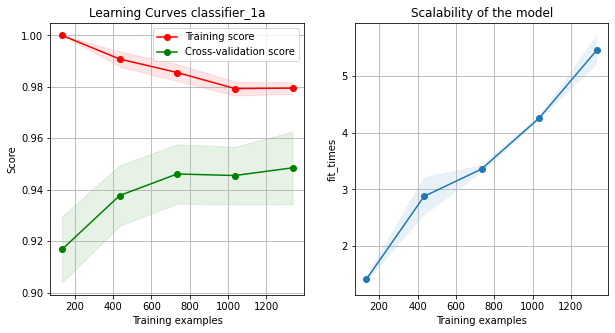

In [37]:
# plot learning curces
plot_learning_curve(loaded_model_sparse_embed, 'Learning Curves classifier_1a', X_train, y_train)

## Feature Engineering + ML Model pipeline

In [38]:
classifier_2 = Pipeline([('fe', FeatureEngineering()),
                  ('classifier', XGBClassifier(scale_pos_weight=estimate))    ])


In [39]:
param_grid_classifier_2 = {'classifier__max_depth' : [3,4,5]}

In [40]:
grid_classifier_2 = GridSearchCV(estimator=classifier_2, param_grid=param_grid_classifier_2, scoring = f2score, cv = 3,  n_jobs= -1, verbose = 4)

In [41]:
grid_classifier_2.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 44.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 44.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('fe',
                                        FeatureEngineering(adj_count=True,
                                                           aux_count=True,
                                                           avg_word_length=False,
                                                           char_count=False,
                                                           char_count_wo_space=False,
                                                           digit_count=False,
                                                           misspelled_count=True,
                                                           ner_count=True,
                                                           noun_count=True,
                                                           propernoun_count=True,
                                                           verb_count=True,
         

In [42]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_2.best_score_))
print("\nBest parameters: ", grid_classifier_2.best_params_)
print("\nBest Estimator: ", grid_classifier_2.best_estimator_)

Best cross-validation score: 0.74

Best parameters:  {'classifier__max_depth': 3}

Best Estimator:  Pipeline(memory=None,
         steps=[('fe',
                 FeatureEngineering(adj_count=True, aux_count=True,
                                    avg_word_length=False, char_count=False,
                                    char_count_wo_space=False,
                                    digit_count=False, misspelled_count=True,
                                    ner_count=True, noun_count=True,
                                    propernoun_count=True, verb_count=True,
                                    word_count=False)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=

In [43]:
print('Train score: {:.4f}'.format(grid_classifier_2.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_classifier_2.score(X_test, y_test)))

Train score: 0.8263
Test score: 0.7928


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

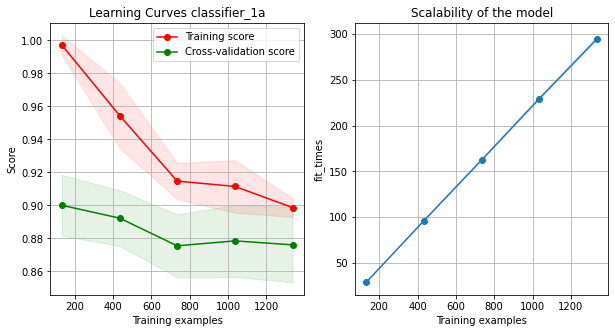

In [44]:
# plot learning curces
plot_learning_curve(grid_classifier_2.best_estimator_, 'Learning Curves classifier_1a', X_train, y_train)

## Featurization (TF-IDF) + Feature Engineering + ML Model pipeline

In [45]:
vectorization = Pipeline([ ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                         ])                        
feature_engineering = FeatureEngineering()
combined_features = FeatureUnion([("vec", vectorization), ("fe", feature_engineering)])

In [46]:
classifier_3 = Pipeline([('cf', combined_features),
                  ('classifier', XGBClassifier(scale_pos_weight=estimate)),
                 ])

In [47]:

param_grid_classifier_3 = {'cf__vec__vectorizer__max_features': [100, 500],
                           'cf__vec__vectorizer__max_df': [0.2, 0.6],
                           'cf__vec__vectorizer__min_df': [0.01, 0.5]}

In [48]:
grid_classifier_3 = GridSearchCV(estimator=classifier_3, param_grid=param_grid_classifier_3, cv = 2,scoring = f2score, n_jobs= -1, verbose = 4 )

In [49]:
grid_classifier_3.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 38.5min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cf',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('vec',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('vectorizer',
                                                                                         TfidfVectorizer(analyzer='word',
                                                                                                         binary=False,
                                                                                                         decode_error='strict',
                                                                                                         dtype=<class 'numpy.float64'>,
                          

In [50]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("Best parameters: ", grid_classifier_3.best_params_)

Best cross-validation score: 0.84
Best parameters:  {'cf__vec__vectorizer__max_df': 0.6, 'cf__vec__vectorizer__max_features': 100, 'cf__vec__vectorizer__min_df': 0.01}


In [51]:
print('Train score: {:.4f}'.format(grid_classifier_3.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_classifier_3.score(X_test, y_test)))

Train score: 0.9740
Test score: 0.8596


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

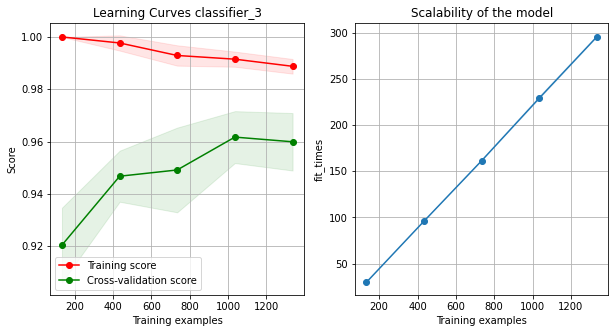

In [52]:
# plot learning curces
# This cell can take upto 30 minutes to run
plot_learning_curve(grid_classifier_3.best_estimator_, 'Learning Curves classifier_3', X_train, y_train)